In [ ]:
!pip install -q peft transformers trl
!pip install -q accelerate
!pip install -q bitsandbytes
!pip install -i https://pypi.org/simple/bitsandbytes
!pip install -q torch

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install -q -U auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/
!pip install -q -U langchain

!pip install -q faiss-gpu
!pip install -q langchain_community
!pip install -q sentence-transformers
!pip install -q evaluate
!pip install -q rquge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
import torch

from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
from langchain import HuggingFacePipeline, PromptTemplate, LLMChain

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("Lucas-Hyun-Lee/gemma-2b-it-Question-generation-en-sft-qlora")

model = AutoModelForCausalLM.from_pretrained("Lucas-Hyun-Lee/gemma-2b-it-Question-generation-en-sft-qlora",
                                             quantization_config=quant_config,
                                             device_map={"": 0})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
doc = """
Di Indonesia, terutama Pulau Jawa, terdapat banyak sekali peninggalan budaya agama Buddha. Salah satu yang terbesar adalah Candi Borobudur.Candi Borobudur terletak di Magelang, Jawa Tengah. Lokasinya berdekatan dengan dua candi Buddha lainnya, yaitu Candi Pawon dan Candi Mendut.

Pada 1991, Candi Borobudur ditetapkan sebagai warisan budaya dunia (World Cultural Heritage) oleh UNESCO. Demikian candi ini menjadi salah satu peninggalan yang sangat penting yang patut untuk dijaga.

Candi Borobudur ditemukan pada 1814. Kala itu, Sir Thomas Stamford Raffles yang menjabat sebagai gubernur jenderal Inggris menerima laporan tentang penemuan candi di Desa Bumisegoro, dekat Magelang. Insinyur Belanda H.C. Cornelius pun diperintahkan untuk menelitinya.
"""

In [ ]:
from transformers import pipeline
import re

def generate_question(context):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

  messages = [{"role": "user", "content": (f"Berikut ini adalah konteks yang diberikan:\n\n{context}\n\n"
        "Berdasarkan konteks di atas, buatkan 5 pertanyaan singkat dan relevan. "
        "Pastikan setiap pertanyaan hanya berfokus pada informasi yang disajikan dalam konteks, menggunakan bahasa yang jelas dan mudah dipahami, dan tidak menanyakan informasi di luar konteks yang diberikan.\n"
        "Buatlah 5 pertanyaan berdasarkan konteks yang diberikan.")}]

  prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  outputs = pipe(prompt, do_sample=True, temperature=0.8, top_k=50, top_p=0.95, max_new_tokens=1000)

  generated_question = outputs[0]["generated_text"][len(prompt):]

  # Define the regular expression pattern
  pattern = r"\d+\.\s+(.+?)\?"

  # Compile the regular expression pattern
  regex = re.compile(pattern)

  # Find all matches in the question list
  matches = regex.findall(generated_question)

  question_list = []
  # Print the extracted texts
  for match in matches:
      question_list.append(match.strip())

  # Menampilkan list pertanyaan
  return question_list

#question = generate_question(doc)
#question

## Generate Answer

Llama3

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "nvidia/Llama3-ChatQA-1.5-8B"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map={"": 0},
        quantization_config=quant_config)

tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
import torch
import transformers

pipeline2 = transformers.pipeline(
        "text-generation",
        model=model_gptq,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_new_tokens=500,
        temperature=0.1,
        return_full_text=False,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id, )

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalL

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from langchain import HuggingFacePipeline, PromptTemplate, LLMChain

In [ ]:
llm = HuggingFacePipeline(pipeline=pipeline2)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


In [ ]:
from transformers import pipeline
from langchain import HuggingFacePipeline

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.2,
    return_full_text= False,
    do_sample = True,
    num_return_sequences=1,
    top_k=10,
)

hf = HuggingFacePipeline(pipeline=pipe)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


Kancil-V1

In [ ]:
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig, LlamaTokenizer

model_id = "afrizalha/Kancil-V1-llama3-4bit"
config = AutoConfig.from_pretrained(model_id)

BNB_CONFIG = BitsAndBytesConfig(load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type="nf4",
                                bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=BNB_CONFIG,
                                             device_map="auto",
                                             trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Unused kwargs: ['quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors.index.json:   0%|          | 0.00/132k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import pipeline
from langchain import HuggingFacePipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.2,
    return_full_text= False,
    do_sample = True,
    num_return_sequences=1,
    top_k=10,
)

hf = HuggingFacePipeline(pipeline=pipe)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


Generate Answer

In [ ]:
def answer_question(context, questions):
  template = """
            SYSTEM: Buatlah satu kalimat jawaban yang singkat, jelas, dan akurat dari pertanyaan yang ada berdasarkan informasi yang telah diberikan.
            CONTEXT: {context}
            USER: {question}
            ASSISTANT:
            """
  answer = []

  prompt_context = PromptTemplate(input_variables=["context", "question"], template=template)

  llm_chain_context = LLMChain(prompt=prompt_context ,llm=hf)

  for count, question in enumerate(questions):
    res =  llm_chain_context({"context": context , "question": question})['text'].strip()
    print(f"==== Pertanyaan {count+1} ====")
    print(f"Pertanyaan : {question}")
    print(f"Jawaban    : {res}\n\n")
    answer.append(res)

  return answer

Selecting Question

In [ ]:
# questions_answers = list(zip(generated_question, answered_question))

def select_questions(questions_answers):
    selected = []
    for i, (question, answer) in enumerate(questions_answers, start=1):
        print(f"Pertanyaan {i}: {question}")
        include = input("Apakah Anda ingin memasukkan pertanyaan ini ke dalam list? (y/n): ")
        if include.lower() == 'y':
            selected.append((question, answer))
    return selected

# selected_questions = select_questions(questions_answers)

# print("\nPertanyaan dan jawaban terpilih:\n")
# for q, a in selected_questions:
#     print(f"Pertanyaan: {q}")
#     print(f"Jawaban: {a}")
#     print()

### Similarity Check

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders import DataFrameLoader
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/QnA_Result (2).csv")
df_question = df[["Pertanyaan"]]
df_question

,Pertanyaan
0,Apa sebab terjadinya pelestarian Borobudur sem...
1,Berapa jumlah total relief di Borobudur
2,Apa kegunaan lorong sempit yang terbentuk oleh...
3,Apa fungsi stupa besar di puncak Borobudur
4,Berapa jumlah stupa di Borobudur dan apa tujua...


In [ ]:
loader = DataFrameLoader(df_question, page_content_column="Pertanyaan").load()

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="firqaaa/indo-sentence-bert-base")
db = FAISS.from_documents(loader, embeddings)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def similarity_check(questions, answers):
  saved_question = []
  saved_answer = []
  threshold = 100

  print("\n\n======================")
  print(f"|   Threshold : {threshold}  |")
  print("======================\n")

  for i in range(len(questions)):
    docs_and_scores = db.similarity_search_with_score(questions[i])
    document, score = docs_and_scores[0]
    print(f"Pertanyaan ke - {i+1}")
    print(f"Pertanyaan : {questions[i]}")
    print(f"===================")

    if score > threshold:
      print(f"Similarity Score : {score}")
      print(f"Pertanyaan Disimpan....\n\n")
      saved_question.append(questions[i])
      saved_answer.append(answers[i])
    else:
      print(f"Similarity Score : {score}")
      print(f"Pertanyaan gagal Disimpan....\n\n")

  return saved_question, saved_answer

# Model Evaluation Using RQUGE

In [ ]:
!pip install rquge

In [ ]:
from evaluate import load
rqugescore = load("alirezamsh/rquge")

generated_questions = ["how is the weather?"]
contexts = ["the weather is sunny"]
answers = ["sunny"]
results = rqugescore.compute(generated_questions=generated_questions, contexts=contexts, answers=answers)

tokenizer_config.json:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/834 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/299 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
def qna_pipeline(context):

    context = ["""Candi Borobudur dibangun oleh Dinasti Sailendra. Candi Borobudur merupakan peninggalan Buddha terbesar di dunia yang dibangun antara tahun 780-840 Masehi. Pada masa itu, Dinasti Sailendra adalah penguasa di wilayah tersebut. Candi Borobudur didirikan sebagai tempat pemujaan Buddha dan tempat ziarah. Candi ini dirancang untuk memberikan petunjuk kepada manusia agar menjauhi nafsu dunia dan mencari pencerahan serta kebijaksanaan menurut ajaran Buddha. Candi Borobudur ditemukan oleh tentara Inggris pada tahun 1814 di bawah pimpinan Sir Thomas Stamford Raffles. Seluruh area candi berhasil dibersihkan pada tahun 1835, sehingga candi ini bisa dipelajari. Borobudur dibangun dengan gaya arsitektur Mandala yang mencerminkan pandangan Buddha tentang alam semesta. Struktur candi ini berbentuk persegi dengan empat pintu masuk dan titik pusat berbentuk lingkaran. Jika dilihat dari luar ke dalam, candi ini terbagi menjadi dua bagian, yaitu bagian luar yang terdiri dari tiga zona yang melambangkan alam dunia dan bagian pusat yang melambangkan alam Nirwana.""",
    ]

    generated_question = generate_question(context)
    generated_question = [text.replace("**", "") for text in generated_question]
    answered_question = answer_question(context, generated_question)

    # RQUGE
    # for i in range(len(selected_questions)):
    #   RQUGE.append(rqugescore.compute(generated_questions=selected_questions[i], contexts=context, answers=selected_answers[i]))

    return generated_question, answered_question

generated_questions_list, answered_question_list = qna_pipeline(contexts)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Apakah tahun pembangunan Candi Borobudur
Jawaban    : Candi Borobudur dibangun antara tahun 780-840 Masehi




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Untuk siapa dan bagaimana Candi Borobudur dibangun
Jawaban    : Candi Borobudur dibangun oleh Dinasti Sailendra untuk menjadi tempat pemujaan Buddha dan tempat ziarah.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Apakah Candi Borobudur merupakan peninggalan Buddha terbesar di dunia
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : Bagaimana tujuan utama Candi Borobudur
Jawaban    : Borobudur dibangun sebagai tempat pemujaan Buddha dan tempat ziarah. Candi ini dirancang untuk memberikan petunjuk kepada manusia agar menjauhi nafsu dunia dan mencari pencerahan serta kebijaksanaan menurut ajaran Buddha.


==== Pertanyaan 5 ====
Pertanyaan : Bagaimana gaya arsitektur yang diterapkan pada Candi Borobudur
Jawaban    : Candi Borobudur dibangun dengan gaya arsitektur Mandala yang mencerminkan pandangan Buddha tentang alam semesta.




In [ ]:
results = rqugescore.compute(generated_questions=list(generated_questions_list), contexts=[doc for i in range(5)], answers=answered_question_list)
print(results["mean_score"])

1.1160250425338745


In [ ]:
def qna_pipeline(context):

    context = ["""Di Indonesia, terutama Pulau Jawa, terdapat banyak sekali peninggalan budaya agama Buddha. Salah satu yang terbesar adalah Candi Borobudur. Candi Borobudur terletak di Magelang, Jawa Tengah. Lokasinya berdekatan dengan dua candi Buddha lainnya, yaitu Candi Pawon dan Candi Mendut. Pada 1991, Candi Borobudur ditetapkan sebagai warisan budaya dunia (World Cultural Heritage) oleh UNESCO. Demikian candi ini menjadi salah satu peninggalan yang sangat penting yang patut untuk dijaga. Candi Borobudur ditemukan pada 1814. Kala itu, Sir Thomas Stamford Raffles yang menjabat sebagai gubernur jenderal Inggris menerima laporan tentang penemuan candi di Desa Bumisegoro, dekat Magelang. Insinyur Belanda H.C. Cornelius pun diperintahkan untuk menelitinya. Kemudian, sejumlah orang Belanda mulai tertarik dan meneliti penemuan Candi Borobudur tersebut. Pada 1835, Hartmann menyuruh anak buahnya untuk membersihkan candi. Ia menemukan sebuah arca Buddha yang belum selesai beserta benda-benda lain termasuk sebilah keris.""",
            ]

    generated_question = generate_question(context)
    generated_question = [text.replace("**", "") for text in generated_question]
    answered_question = answer_question(context, generated_question)

    # RQUGE
    # for i in range(len(selected_questions)):
    #   RQUGE.append(rqugescore.compute(generated_questions=selected_questions[i], contexts=context, answers=selected_answers[i]))

    return generated_question, answered_question

generated_questions_list, answered_question_list = qna_pipeline(contexts)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Di mana dan ketika Candi Borobudur terletak
Jawaban    : Candi Borobudur terletak di Magelang, Jawa Tengah. Candi Borobudur ditemukan pada 1814.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Di tahun apa Candi Borobudur ditetapkan sebagai warisan budaya dunia
Jawaban    : Candi Borobudur ditetapkan sebagai warisan budaya dunia pada tahun 1991.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Nama tempat di Desa Bumisegoro di mana Candi Borobudur ditemukan
Jawaban    : Candi Borobudur ditemukan di Desa Bumisegoro




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : siapa saja insinyur yang mempengaruhi penemuan Candi Borobudur
Jawaban    : Candi Borobudur ditemukan pada 1814. Kala itu, Sir Thomas Stamford Raffles yang menjabat sebagai gubernur jenderal Inggris menerima laporan tentang penemuan candi di Desa Bumisegoro, dekat Magelang. Insinyur Belanda H.C. Cornelius pun diperintahkan untuk menelitinya. Kemudian, sejumlah orang Belanda mulai tertarik dan meneliti penemuan Candi Borobudur tersebut. Pada 1835, Hartmann menyuruh anak buahnya untuk membersihkan candi. Ia menemukan sebuah arca Buddha yang belum selesai beserta benda-benda lain termasuk sebilah keris.


==== Pertanyaan 5 ====
Pertanyaan : Apakah ada informasi tentang orang-orang yang menemukan dan mengekstrak benda-benda dari Candi Borobudur
Jawaban    : 




In [ ]:
results = rqugescore.compute(generated_questions=list(generated_questions_list), contexts=[doc for i in range(5)], answers=answered_question_list)
print(results["mean_score"])

2.3159323930740356


In [ ]:
def qna_pipeline(context):

    context = ["""Pada 1885, J.W. Ijzerman membuka dasar candi borobudur dan ia menemukan relief yang kemudian dikenal relief Karmawibhangga dengan jumlah panil sebanyak 160 buah. Saat ditemukan, keadaan Candi Borobudur sangat memprihatinkan. Oleh sebab itu, van Erp memugar bagian candi yang berbentuk oval di tingkat 7, 8, dan 9 pada 1907. Ia menyusun kembali stupa-stupa dan pemugaran selesai pada 1911. Kondisi Candi Borobudur kembali rusak karena proses alam. Bagian-bagian lain di candi yang belum sempat tertangani oleh van Erp pun amblas dan dindingnya miring. Melihat itu, UNESCO dan lembaga lain menginisiasi pemugaran. Pemugaran kali ini dipimpin oleh Prof Dr R Soekmono dan dibantu Ir Rooseno untuk segi konstruksinya. Proyek pemugaran kedua berlangsung antara tahun 1973-1983. Peresmian dilakukan pada 23 Februari 1983 oleh Presiden Soeharto.""",
            ]

    generated_question = generate_question(context)
    generated_question = [text.replace("**", "") for text in generated_question]
    answered_question = answer_question(context, generated_question)

    # RQUGE
    # for i in range(len(selected_questions)):
    #   RQUGE.append(rqugescore.compute(generated_questions=selected_questions[i], contexts=context, answers=selected_answers[i]))

    return generated_question, answered_question

generated_questions_list, answered_question_list = qna_pipeline(contexts)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Berapakah jumlah panil relief yang ditemukan di Candi Borobudur pada 1885
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Apa tanggal dan pihak yang memugar bagian candi Candi Borobudur pada 1907
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Apakah kondisi Candi Borobudur setelah pemugaran
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : Apa tujuan dari pemugaran Candi Borobudur pada 1983
Jawaban    : Pemugaran Candi Borobudur pada 1983 bertujuan untuk memperbaiki kondisi candi yang rusak karena proses alam.


==== Pertanyaan 5 ====
Pertanyaan : Apakah proyek pemugaran kedua Candi Borobudur berlangsung selama berapa tahun
Jawaban    : 




In [ ]:
results = rqugescore.compute(generated_questions=list(generated_questions_list), contexts=[doc for i in range(5)], answers=answered_question_list)
print(results["mean_score"])

1.2690636396408081


In [ ]:
def qna_pipeline(context):

    context = ["""Candi Borobudur menjadi salah satu tempat wisata sejarah yang bisa dikunjungi wisatawan ketika berlibur di Jawa Tengah maupun Daerah Istimewa Yogyakarta (DIY). Dari Titik Nol Kilometer di Kota Yogyakarta, misalnya, jaraknya mencapai 41 kilometer (km) dengan durasi perjalanan kira-kira satu jam.  Sementara itu, jika dari Kabupaten Magelang, Jawa Tengah, maka jaraknya hingga 31 km dengan waktu tempuh hampir satu jam. Candi Borobudur dikenal megah, diperkirakan pembangunannya membutuhkan dua juta potong batu.  Batu-batu tersebut berasal dari sungai di sekitar candi dengan volume seluruhnya sekitar 55.000 meter kubik.  Panjang bangunan candi mencapai 121,66 meter dengan lebar 121,38 meter. Lalu,  tingginya mencapai sekitar 35,40 meter. Bentuk bangunan candi berupa sembilan teras berundak dan ada sebuah stupa induk di bagian puncaknya.  Terdapat enam teras berdenah dengan bentuk persegi, serta tiga teras berdenah dengan bentuk lingkaran.  Jika dilihat menurut pembagian vertikal secara filosofis, ada tiga tingkat, yakni Kamadhatu, Rupadhatu, dan Arupadhatu. Sementara itu, berdasarkan pembagian vertikal secara teknis, terdapat bagian bawah, tengah, dan atas. Ada sejumlah anak tangga dari keempat penjuru utama, sedangkan pintu masuk utamanya ada di sebelah timur dengan ber-pradaksina. Pradaksina adalah prosesi dalam agama Buddha dengan memutari candi searah jarum jam sebanyak tiga kali.""",
            ]

    generated_question = generate_question(context)
    generated_question = [text.replace("**", "") for text in generated_question]
    answered_question = answer_question(context, generated_question)

    # RQUGE
    # for i in range(len(selected_questions)):
    #   RQUGE.append(rqugescore.compute(generated_questions=selected_questions[i], contexts=context, answers=selected_answers[i]))

    return generated_question, answered_question

generated_questions_list, answered_question_list = qna_pipeline(contexts)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Bagaimana panjang bangunan Candi Borobudur
Jawaban    : Panjang bangunan Candi Borobudur mencapai 121,66 meter




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Berapakah volume total batu yang digunakan untuk membangun Candi Borobudur
Jawaban    : 55.000 meter kubik




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Berapakah tinggi bangunan Candi Borobudur
Jawaban    : Tinggi bangunan Candi Borobudur mencapai sekitar 35,40 meter.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : Bagaimana banyak tingkat dalam bangunan Candi Borobudur
Jawaban    : Ada tiga tingkat dalam bangunan Candi Borobudur, yakni Kamadhatu, Rupadhatu, dan Arupadhatu.


==== Pertanyaan 5 ====
Pertanyaan : Apakah ada pintu masuk utamanya di sebelah apa dari bangunan Candi Borobudur
Jawaban    : 




In [ ]:
results = rqugescore.compute(generated_questions=list(generated_questions_list), contexts=[doc for i in range(5)], answers=answered_question_list)
print(results["mean_score"])

1.5740139484405518


In [ ]:
def qna_pipeline(context):

    context = ["""Candi Borobudur, yang berlokasi di Magelang, Jawa Tengah, Indonesia, merupakan sebuah monumen spektakuler yang mencerminkan kekayaan warisan budaya daerah tersebut. Dibangun pada abad ke-9 oleh Dinasti Sailendra, bangunan ini bukan hanya sebagai tempat ibadah, melainkan juga sebagai karya arsitektur yang memukau. Terletak dengan anggun di puncak bukit, candi ini dikelilingi oleh hamparan pepohonan hijau yang menciptakan suasana damai. Keelokan strukturnya mencerminkan perpaduan unik antara gaya arsitektur Indonesia dan seni India. Candi ini memiliki sembilan platform bertingkat, di setiap tingkatnya dihiasi dengan relief batu yang kompleks, menggambarkan ajaran Buddha dan kisah rakyat Jawa. Kompleks ini terdiri dari enam teras berbentuk bujur sangkar dengan tiga pelataran melingkar, dihiasi dengan 2.672 panel relief, dan aslinya memuat 504 arca Buddha. Stupa utama terbesar berada di tengah, menjadi puncak bangunan ini, dan dikelilingi oleh tiga baris melingkar 72 stupa berlubang yang menampung arca Buddha tengah duduk dalam posisi teratai sempurna dengan mudra Dharmachakra (memutar roda dharma). Sejarah mencatat bahwa Borobudur ditinggalkan pada abad ke-10 ketika pusat Kerajaan Mataram Kuno dipindahkan ke Jawa Timur oleh Pu Sindok. Kesadaran global terhadap keberadaan candi ini muncul setelah penemuan pada tahun 1814 oleh Sir Thomas Stamford Raffles, yang saat itu menjabat sebagai Gubernur Jenderal Inggris di Jawa. Sampai saat ini, Borobudur masih menjadi tempat ziarah keagamaan, di mana setiap tahun umat Buddha dari seluruh Indonesia dan luar negeri berkumpul untuk merayakan Trisuci Waisak."""
]

    generated_question = generate_question(context)
    generated_question = [text.replace("**", "") for text in generated_question]
    answered_question = answer_question(context, generated_question)

    # RQUGE
    # for i in range(len(selected_questions)):
    #   RQUGE.append(rqugescore.compute(generated_questions=selected_questions[i], contexts=context, answers=selected_answers[i]))

    return generated_question, answered_question

generated_questions_list, answered_question_list = qna_pipeline(contexts)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Di mana dan saat dibangun Candi Borobudur
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Bagaimana desain dan struktur bangunan Candi Borobudur
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Apa jenis dan jumlah relief pada bangunan Candi Borobudur
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : Bagaimana simbolisme dan makna ajaran Buddha dan cerita rakyat yang ditampilkan di bangunan
Jawaban    : 


==== Pertanyaan 5 ====
Pertanyaan : Bagaimana peran Candi Borobudur dalam budaya Indonesia
Jawaban    : 




In [ ]:
results = rqugescore.compute(generated_questions=list(generated_questions_list), contexts=[doc for i in range(5)], answers=answered_question_list)
print(results["mean_score"])

1.3238594770431518


In [ ]:
overall_mean_score = (1.1160250425338745+2.3159323930740356+1.2690636396408081+1.5740139484405518+1.3238594770431518) / 5
print(f"Overall mean score: {overall_mean_score}")

Overall mean score: 1.5197789001464845


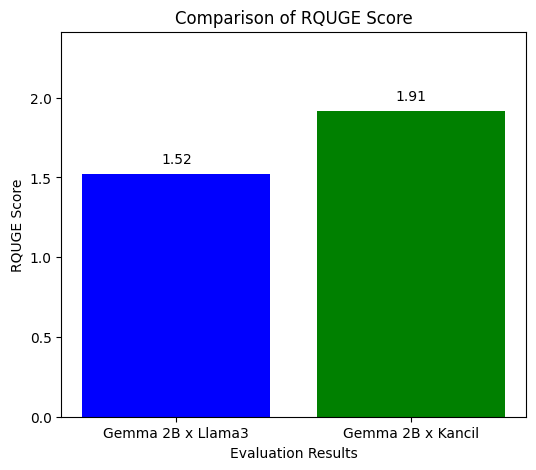

In [ ]:
import matplotlib.pyplot as plt

# Sample overall mean scores
scores = [1.5197789001464845, 1.9133486557006836]
labels = ['Gemma 2B x Llama3', 'Gemma 2B x Kancil']

# Create a bar plot
plt.figure(figsize=(6, 5))
plt.bar(labels, scores, color=['blue', 'green'])
plt.xlabel('Evaluation Results')
plt.ylabel('RQUGE Score')
plt.title('Comparison of RQUGE Score')
plt.ylim(0, max(scores) + 0.5)

# Annotate the scores on the bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.05, f'{score:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
def qna_pipeline(contexts):
    all_generated_questions = []
    all_answered_questions = []

    for context in contexts:
        # Generate questions and answers
        generated_question = generate_question(context)
        generated_question = [text.replace("**", "") for text in generated_question]
        answered_question = answer_question(context, generated_question)

        all_generated_questions.append(generated_question)
        all_answered_questions.append(answered_question)

    return all_generated_questions, all_answered_questions

contexts = ["""Candi Borobudur dibangun oleh Dinasti Sailendra. Candi Borobudur merupakan peninggalan Buddha terbesar di dunia yang dibangun antara tahun 780-840 Masehi. Pada masa itu, Dinasti Sailendra adalah penguasa di wilayah tersebut. Candi Borobudur didirikan sebagai tempat pemujaan Buddha dan tempat ziarah. Candi ini dirancang untuk memberikan petunjuk kepada manusia agar menjauhi nafsu dunia dan mencari pencerahan serta kebijaksanaan menurut ajaran Buddha. Candi Borobudur ditemukan oleh tentara Inggris pada tahun 1814 di bawah pimpinan Sir Thomas Stamford Raffles. Seluruh area candi berhasil dibersihkan pada tahun 1835, sehingga candi ini bisa dipelajari. Borobudur dibangun dengan gaya arsitektur Mandala yang mencerminkan pandangan Buddha tentang alam semesta. Struktur candi ini berbentuk persegi dengan empat pintu masuk dan titik pusat berbentuk lingkaran. Jika dilihat dari luar ke dalam, candi ini terbagi menjadi dua bagian, yaitu bagian luar yang terdiri dari tiga zona yang melambangkan alam dunia dan bagian pusat yang melambangkan alam Nirwana.""",
            """Di Indonesia, terutama Pulau Jawa, terdapat banyak sekali peninggalan budaya agama Buddha. Salah satu yang terbesar adalah Candi Borobudur. Candi Borobudur terletak di Magelang, Jawa Tengah. Lokasinya berdekatan dengan dua candi Buddha lainnya, yaitu Candi Pawon dan Candi Mendut. Pada 1991, Candi Borobudur ditetapkan sebagai warisan budaya dunia (World Cultural Heritage) oleh UNESCO. Demikian candi ini menjadi salah satu peninggalan yang sangat penting yang patut untuk dijaga. Candi Borobudur ditemukan pada 1814. Kala itu, Sir Thomas Stamford Raffles yang menjabat sebagai gubernur jenderal Inggris menerima laporan tentang penemuan candi di Desa Bumisegoro, dekat Magelang. Insinyur Belanda H.C. Cornelius pun diperintahkan untuk menelitinya. Kemudian, sejumlah orang Belanda mulai tertarik dan meneliti penemuan Candi Borobudur tersebut. Pada 1835, Hartmann menyuruh anak buahnya untuk membersihkan candi. Ia menemukan sebuah arca Buddha yang belum selesai beserta benda-benda lain termasuk sebilah keris.""",
            """Pada 1885, J.W. Ijzerman membuka dasar candi borobudur dan ia menemukan relief yang kemudian dikenal relief Karmawibhangga dengan jumlah panil sebanyak 160 buah. Saat ditemukan, keadaan Candi Borobudur sangat memprihatinkan. Oleh sebab itu, van Erp memugar bagian candi yang berbentuk oval di tingkat 7, 8, dan 9 pada 1907. Ia menyusun kembali stupa-stupa dan pemugaran selesai pada 1911. Kondisi Candi Borobudur kembali rusak karena proses alam. Bagian-bagian lain di candi yang belum sempat tertangani oleh van Erp pun amblas dan dindingnya miring. Melihat itu, UNESCO dan lembaga lain menginisiasi pemugaran. Pemugaran kali ini dipimpin oleh Prof Dr R Soekmono dan dibantu Ir Rooseno untuk segi konstruksinya. Proyek pemugaran kedua berlangsung antara tahun 1973-1983. Peresmian dilakukan pada 23 Februari 1983 oleh Presiden Soeharto.""",
            """Candi Borobudur menjadi salah satu tempat wisata sejarah yang bisa dikunjungi wisatawan ketika berlibur di Jawa Tengah maupun Daerah Istimewa Yogyakarta (DIY). Dari Titik Nol Kilometer di Kota Yogyakarta, misalnya, jaraknya mencapai 41 kilometer (km) dengan durasi perjalanan kira-kira satu jam.  Sementara itu, jika dari Kabupaten Magelang, Jawa Tengah, maka jaraknya hingga 31 km dengan waktu tempuh hampir satu jam. Candi Borobudur dikenal megah, diperkirakan pembangunannya membutuhkan dua juta potong batu.  Batu-batu tersebut berasal dari sungai di sekitar candi dengan volume seluruhnya sekitar 55.000 meter kubik.  Panjang bangunan candi mencapai 121,66 meter dengan lebar 121,38 meter. Lalu,  tingginya mencapai sekitar 35,40 meter. Bentuk bangunan candi berupa sembilan teras berundak dan ada sebuah stupa induk di bagian puncaknya.  Terdapat enam teras berdenah dengan bentuk persegi, serta tiga teras berdenah dengan bentuk lingkaran.  Jika dilihat menurut pembagian vertikal secara filosofis, ada tiga tingkat, yakni Kamadhatu, Rupadhatu, dan Arupadhatu. Sementara itu, berdasarkan pembagian vertikal secara teknis, terdapat bagian bawah, tengah, dan atas. Ada sejumlah anak tangga dari keempat penjuru utama, sedangkan pintu masuk utamanya ada di sebelah timur dengan ber-pradaksina. Pradaksina adalah prosesi dalam agama Buddha dengan memutari candi searah jarum jam sebanyak tiga kali.""",
            """Candi Borobudur, yang berlokasi di Magelang, Jawa Tengah, Indonesia, merupakan sebuah monumen spektakuler yang mencerminkan kekayaan warisan budaya daerah tersebut. Dibangun pada abad ke-9 oleh Dinasti Sailendra, bangunan ini bukan hanya sebagai tempat ibadah, melainkan juga sebagai karya arsitektur yang memukau. Terletak dengan anggun di puncak bukit, candi ini dikelilingi oleh hamparan pepohonan hijau yang menciptakan suasana damai. Keelokan strukturnya mencerminkan perpaduan unik antara gaya arsitektur Indonesia dan seni India. Candi ini memiliki sembilan platform bertingkat, di setiap tingkatnya dihiasi dengan relief batu yang kompleks, menggambarkan ajaran Buddha dan kisah rakyat Jawa. Kompleks ini terdiri dari enam teras berbentuk bujur sangkar dengan tiga pelataran melingkar, dihiasi dengan 2.672 panel relief, dan aslinya memuat 504 arca Buddha. Stupa utama terbesar berada di tengah, menjadi puncak bangunan ini, dan dikelilingi oleh tiga baris melingkar 72 stupa berlubang yang menampung arca Buddha tengah duduk dalam posisi teratai sempurna dengan mudra Dharmachakra (memutar roda dharma). Sejarah mencatat bahwa Borobudur ditinggalkan pada abad ke-10 ketika pusat Kerajaan Mataram Kuno dipindahkan ke Jawa Timur oleh Pu Sindok. Kesadaran global terhadap keberadaan candi ini muncul setelah penemuan pada tahun 1814 oleh Sir Thomas Stamford Raffles, yang saat itu menjabat sebagai Gubernur Jenderal Inggris di Jawa. Sampai saat ini, Borobudur masih menjadi tempat ziarah keagamaan, di mana setiap tahun umat Buddha dari seluruh Indonesia dan luar negeri berkumpul untuk merayakan Trisuci Waisak."""
]

generated_questions_list, answered_question_list = qna_pipeline(contexts)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Siapakah Sailendra
Jawaban    : Sailendra adalah dinasti yang membangun candi Borobudur




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Berapa besar kompleks candi Borobudur dan berapa luasnya
Jawaban    : Kompleks candi Borobudur memiliki luas sekitar 2.500 meter persegi, dengan tinggi sekitar 42 meter.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Mengapa Borobudur terkenal sebagai candi Buddha terbesar di dunia
Jawaban    : Borobudur terkenal sebagai candi Buddha terbesar di dunia karena merupakan peninggalan Buddha yang dibangun antara tahun 780-840 Masehi.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : Siapakah Sir Thomas Stamford Raffles dan bagaimana sejarah ditemukannya Borobudur
Jawaban    : 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 5 ====
Pertanyaan : Bagaimana arsitektur dari Borobudur
Jawaban    : Borobudur dibangun dengan gaya arsitektur Mandala yang mencerminkan pandangan Buddha tentang alam semesta. Struktur candi ini berbentuk persegi dengan empat pintu masuk dan titik pusat berbentuk lingkaran. Jika dilihat dari luar ke dalam, candi ini terbagi menjadi dua bagian, yaitu bagian luar yang terdiri dari tiga zona yang melambangkan alam dunia dan bagian pusat yang melambangkan alam Nirwana.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 1 ====
Pertanyaan : Candi Borobudur ditetapkan sebagai warisan budaya dunia oleh UNESCO pada tahun berapa
Jawaban    : 1991




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 2 ====
Pertanyaan : Candi Borobudur ditemukan pada tahun berapa
Jawaban    : Candi Borobudur ditemukan pada tahun 1814.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 3 ====
Pertanyaan : Sir Thomas Stamford Raffles menjabat sebagai gubernur jenderal Inggris pada tahun berapa
Jawaban    : 1814




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 4 ====
Pertanyaan : Sebilah keris ditemukan bersamaan dengan apa
Jawaban    : Candi Borobudur




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


==== Pertanyaan 5 ====
Pertanyaan : Candi Borobudur terletak di mana
Jawaban    : Candi Borobudur terletak di Magelang, Jawa Tengah.




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [ ]:
overall_mean_score = sum(mean_scores) / len(mean_scores)
print(f"Overall mean score: {overall_mean_score}")

Overall mean score: 1.8222620058059689


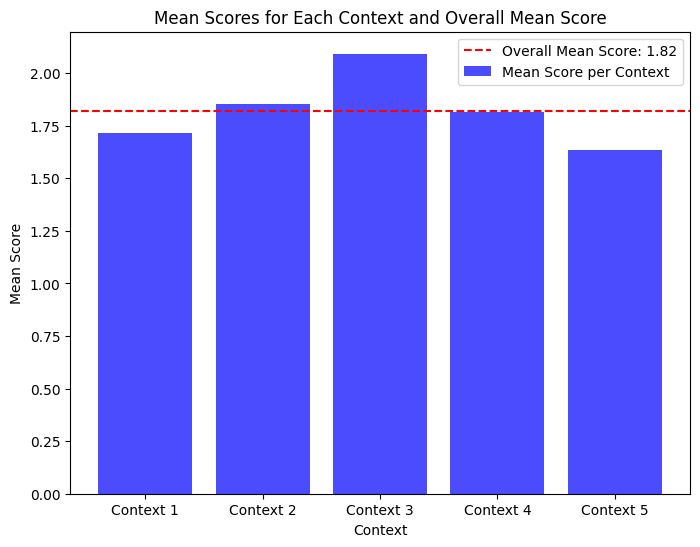

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
context_indices = range(1, len(contexts) + 1)
plt.bar(context_indices, mean_scores, color='blue', alpha=0.7, label='Mean Score per Context')

# Plot the overall mean score
plt.axhline(y=overall_mean_score, color='red', linestyle='--', label=f'Overall Mean Score: {overall_mean_score:.2f}')

# Add labels and title
plt.xlabel('Context')
plt.ylabel('Mean Score')
plt.title('Mean Scores for Each Context and Overall Mean Score')
plt.xticks(context_indices, [f'Context {i}' for i in context_indices])
plt.legend()

# Show the plot
plt.show()